# Advanced: Nelder-Mead Optimizer

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

## Create fake "observations"

We'll create the same fake "observations" as in the [Inverse Paper Examples](../examples/inverse_paper_examples.ipynb).

For the sake of efficiency for this example, we'll use the ellc backend.  In practice, this is only safe for areas of the parameter space where [phoebe](../api/phoebe.parameters.compute.phoebe.md) and [ellc](../api/phoebe.parameters.compute.ellc.md) are in sufficient agreement.

In [3]:
b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0)
b.set_value('vgamma', 80)

lctimes = phoebe.linspace(0, 10, 1005)
rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('lc', compute_times=lctimes)
b.add_dataset('rv', compute_times=rvtimes)

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')
b.run_compute(compute='fastcompute')

fluxes = b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape) * 0.01
fsigmas = np.ones_like(lctimes) * 0.02

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

100%|██████████| 3/3 [00:00<00:00, 51.59it/s]


In [4]:
b = phoebe.default_binary()

b.add_dataset('lc', 
              compute_phases=phoebe.linspace(0,1,201),
              times=lctimes, 
              fluxes=fluxes, 
              sigmas=fsigmas, 
              dataset='lc01')

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=rvtimes, 
              rvs={'primary': rvsA, 'secondary': rvsB}, 
              sigmas=rvsigmas, 
              dataset='rv01')

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')

We'll set the initial model to be *close* to the correct values, but not exact.  In practice, we would instead have to use a combination of manual tweaking, [LC estimators](./LC_estimators.ipynb), and [RV_estimators](./RV_estimators.ipynb) to get in the rough parameter space of the solution before starting to use optimizers.

In [5]:
b.set_value('sma@binary', 7+0.5)
b.set_value('incl@binary', 80+10)
b.set_value('q', 0.3+0.1)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0-0.3)

In [6]:
b.run_compute(compute='fastcompute', model='orig_model')

100%|██████████| 3/3 [00:00<00:00, 123.69it/s]


<ParameterSet: 7 parameters | kinds: rv, lc>

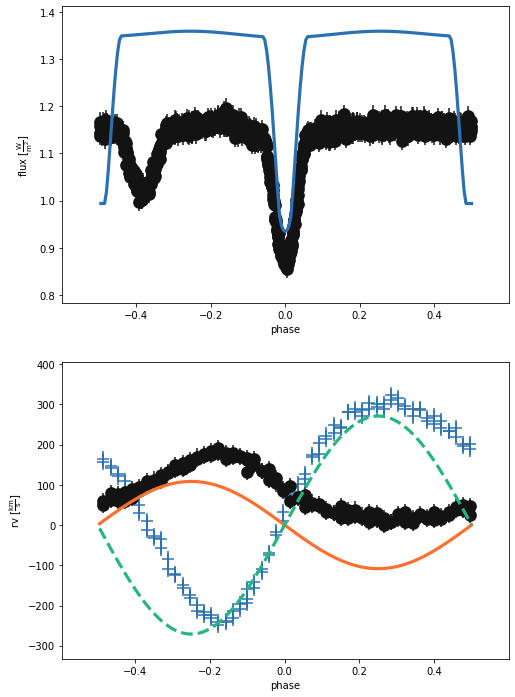

In [7]:
_ = b.plot(x='phases', show=True)

## Nelder-Mead Options

As with any solver, we call [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md) and this time pass [optimizer.nelder_mead](../api/phoebe.parameters.solver.optimizer.nelder_mead.md).

In [8]:
b.add_solver('optimizer.nelder_mead', solver='nm_solver')

<ParameterSet: 12 parameters | qualifiers: comments, fatol, compute, maxiter, xatol, priors, priors_combine, expose_lnprobabilities, initial_values, adaptive, maxfev, fit_parameters>

This adds new parameters to our bundle with the options for running nelder-mead.

In [9]:
print(b.filter(solver='nm_solver'))

ParameterSet: 11 parameters
        comments@nm_solver@solver: 
         compute@nm_solver@solver: phoebe01
   expose_lnprobabilities@nm_s...: False
   fit_parameters@nm_solver@so...: []
   initial_values@nm_solver@so...: {}
          priors@nm_solver@solver: []
         maxiter@nm_solver@solver: 1000000
          maxfev@nm_solver@solver: 1000000
        adaptive@nm_solver@solver: False
           xatol@nm_solver@solver: 0.0001
           fatol@nm_solver@solver: 0.0001


Here we get to choose which set of compute-options will be used while optimizing (we'll choose the ellc compute options we called 'fastcompute' just for the sake of efficiency)

In [10]:
b.set_value('compute', solver='nm_solver', value='fastcompute')

We'll also set `maxiter` and `maxfev` to smaller values (these are just passed directly to [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [11]:
b.set_value('maxiter', 1000)
b.set_value('maxfev', 1000)

The `fit_parameters` parameter takes a list of twigs (see the [general concepts tutorial](./general_concepts.ipynb) for a refresher).  These parameters will be those that are optimized.  By default, each parameter will start at its current face-value.  To change the starting positions, you can either change the face-values in the bundle, or pass alternate starting positions to `initial_values` (as a dictionary of twig-value pairs).

In [12]:
print(b.get_parameter('fit_parameters'))

Parameter: fit_parameters@nm_solver@solver
                       Qualifier: fit_parameters
                     Description: parameters (as twigs) to optimize
                           Value: []
                         Choices: t0@system, ra@system, dec@system, distance@system, vgamma@system, ebv@system, Av@system, Rv@system, requiv@primary@star@component, requiv_max@primary@star@component, requiv_min@primary@star@component, teff@primary@star@component, abun@primary@star@component, logg@primary@star@component, syncpar@primary@star@component, period@primary@star@component, freq@primary@star@component, pitch@primary@star@component, yaw@primary@star@component, incl@primary@star@component, long_an@primary@star@component, gravb_bol@primary@star@component, irrad_frac_refl_bol@primary@star@component, irrad_frac_lost_bol@primary@star@component, mass@primary@star@component, requiv@secondary@star@component, requiv_max@secondary@star@component, requiv_min@secondary@star@component, teff@seconda

In [13]:
print(b.get_parameter('initial_values'))

Parameter: initial_values@nm_solver@solver
                       Qualifier: initial_values
                     Description: twig-value pairs to (optionally) override the current values in the bundle.  Any items not in fit_parameters will be silently ignored.
                           Value: {}
                  Constrained by: 
                      Constrains: None
                      Related to: None



`fit_parameters` does accept partial-twigs as well as wildcard matching.  To see the full list of matched parameters for the current set value, you can pass `expand=True` to `get_value`.

In [14]:
b.set_value('fit_parameters', ['teff', 'requiv'])

In [15]:
b.get_value('fit_parameters', expand=True)

['teff@primary@star@component',
 'teff@secondary@star@component',
 'requiv@primary@star@component',
 'requiv@secondary@star@component']

For this example, let's try to fit the RV first, so we'll optimize `q`, `vgamma`, and `t0_supconj`.

In [16]:
b.set_value('fit_parameters', ['q', 'vgamma', 't0_supconj'])

In [17]:
b.get_value('fit_parameters', expand=True)

['q@binary@orbit@component',
 'vgamma@system',
 't0_supconj@binary@orbit@component']

Note that the optimizer options also contains the ability to set "priors".  If set (to the label of a [distribution set](./distributions.ipynb), these will be included in the cost function and can be used to limit the range that a parameter will be allowed to explore within the optimizer.

## Running Nelder-Mead

Once our options are set, we can call [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md), pass the label of our solver ('nm_solver' in this case), and optionally a label for the resulting "solution" (same as labeling the results from [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) with a "model").

In this case, we want to fit **only** the RVs, so we'll disable the LCs in the compute options that we're using.

In [18]:
print(b.filter(qualifier='enabled', compute='fastcompute'))

ParameterSet: 2 parameters
   enabled@lc01@fastcompute@co...: True
   enabled@rv01@fastcompute@co...: True


In [19]:
b.disable_dataset('lc01', compute='fastcompute')

<ParameterSet: 24 parameters | components: binary, primary, secondary>

In [20]:
print(b.filter(qualifier='enabled', compute='fastcompute'))

ParameterSet: 2 parameters
   enabled@lc01@fastcompute@co...: False
   enabled@rv01@fastcompute@co...: True


In [21]:
b.run_solver('nm_solver', solution='nm_sol')

20100it [02:41, 236.89it/s]                       

<ParameterSet: 13 parameters | qualifiers: comments, adopt_values, fitted_twigs, fitted_values, fitted_units, message, nfev, adopt_parameters, initial_values, niter, fitted_uniqueids, success, adopt_distributions>

## Interpreting the Returned Solution

We can now look at the new parameters this has added to the bundle:

In [22]:
print(b.filter(solution='nm_sol'))

ParameterSet: 13 parameters
R  fitted_uniqueids@nm_sol@sol...: ['sMPoHmWWZaAKMjdqtNItswEOYoJvfK' 'nMZNAqIGcPziCEOAUfjtPYQxorJuKE'
 'rCsuCkYdKKFHpacuMaoFaxiBPPRMtH']
R    fitted_twigs@nm_sol@solution: ['q@binary@orbit@component' 'vgamma@system'
 't0_supconj@binary@orbit@component']
   adopt_parameters@nm_sol@sol...: ['q@binary@orbit@component', 'vgamma@system', 't0_supconj@binary@orbit@component']
   adopt_distributions@nm_sol@...: False
     adopt_values@nm_sol@solution: True
R         message@nm_sol@solution: Optimization terminated successfully.
R            nfev@nm_sol@solution: 357
R           niter@nm_sol@solution: 201
R         success@nm_sol@solution: True
R  initial_values@nm_sol@solution: [0.4 0.  0.1]
R   fitted_values@nm_sol@solution: [ 0.34970629 79.56392648  0.15472398]
R    fitted_units@nm_sol@solution: ['' 'km / s' 'd']
         comments@nm_sol@solution: 


And then adopt the final parameter values, via [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md).  By passing `trial_run=True`, we can see what changes will be made without actually changing the face-values in the bundle.

In [23]:
print(b.adopt_solution(trial_run=True))

ParameterSet: 3 parameters
         q@binary@orbit@component: 0.3497062914145408
                    vgamma@system: 79.56392648057567 km / s
   t0_supconj@binary@orbit@com...: 0.15472398438567175 d


Note that by default, all fitted parameters will be adopted.  But we can change this by setting `adopt_parameters` (in the solution) or by passing `adopt_parameters` directly to `adopt_solution`.

In [24]:
print(b.adopt_solution(trial_run=True, adopt_parameters=['q']))

ParameterSet: 1 parameters
         q@binary@orbit@component: 0.3497062914145408


To see the affect of these new parameter-values on the model without adopting their values, we can also pass the solution directly to [run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) with `sample_from`.

In [25]:
b.run_compute(compute='fastcompute', sample_from='nm_sol', model='nm_model')


100%|██████████| 2/2 [00:00<00:00, 222.05it/s]


<ParameterSet: 10 parameters | components: primary, secondary>

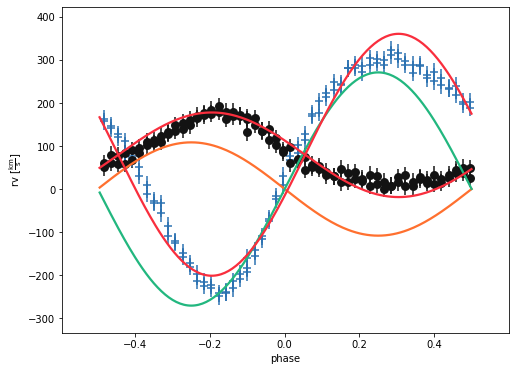

In [26]:
_ = b.plot(kind='rv', x='phases', 
           linestyle={'model': 'solid'},
           color={'nm_model': 'red', 'model_orig': 'green'},
           show=True)

Just by looking, we can see that this isn't quite perfect yet and could use some additional optimization, but is definitely a step in the right direction!

If you're using an [alternate backend](./alternate_backends.ipynb) for the sake of efficiency (as we are here), it is always a good idea to compare against a full robust forward model before adopting results (as various backends/options have different assumptions and the wrappers calling these other codes are not perfect 1:1 representations).

In [27]:
b.run_compute(compute='phoebe01', sample_from='nm_sol', model='nm_model_phoebe')


100%|██████████| 201/201 [00:03<00:00, 53.78it/s]


<ParameterSet: 12 parameters | kinds: rv, lc>

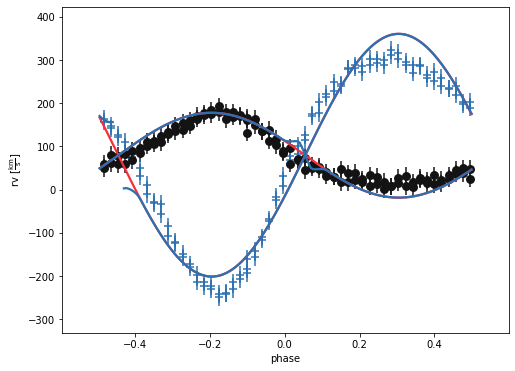

In [28]:
_ = b.plot(model='nm_model*', kind='rv', x='phases', 
           linestyle={'model': 'solid'},
           color={'nm_model': 'red', 'nm_model_phoebe': 'blue'},
           show=True)

Here, for example, we see that our 'fastcompute' is ignoring the [Rossiter-McLaughlin](../examples/rossiter_mclaughlin.ipynb) effect.  In practice, since we have data in this region, this would be a cause for concern.  For this example, our fake data was created using the same 'fastcompute' options... so we won't worry about it.

## Adopting Solution

To "permananetly" adopt these proposed changes, we call [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) (and can optionally pass `remove_solution=True` to cleanup the solution parameters if they will no longer be needed)

In [29]:
b.adopt_solution('nm_sol')

<ParameterSet: 18 parameters | contexts: dataset, system, component>

In [30]:
print(b.filter(qualifier=['q', 'vgamma', 't0_supconj'], context=['component', 'system']))

ParameterSet: 3 parameters
                    vgamma@system: 79.56392648057567 km / s
      t0_supconj@binary@component: 0.15472398438567175 d
               q@binary@component: 0.3497062914145408


20100it [03:00, 236.89it/s]

# Next Up

Once the model agrees well with the observations and the residuals show no systematics, then its time to use samplers to estimate parameter uncertainties:

* [Advanced: Emcee Sampler](./emcee.ipynb)